# Análise de vendas - Case comercial para Varejo

## Introdução

Este notebook tem como propósito examinar os dados de vendas de uma empresa do setor varejista, a fim de responder a questões específicas formuladas pela equipe da área Comercial. Por meio da manipulação e análise de dados transacionais, busquei extrair insights sobre os hábitos de compra dos clientes, considerando variáveis como classe social, cor, tamanho e localização geográfica (Unidade da Federação).

As análises desenvolvidas aqui visam compreender tendências de consumo e identificar possíveis oportunidades de negócio, utilizando filtros estratégicos (como características dos produtos e períodos de venda) e aplicando métodos estatísticos quando apropriado. Cada seção do notebook trata de uma das perguntas propostas, com visualizações e interpretações objetivas dos resultados alcançados.

## Bibliotecas

In [1]:
# instalação - execute apenas uma vez ou quando necessário
%pip install duckdb pandas matplotlib seaborn openpyxl scipy statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import duckdb

## Carregamento e Pré-processamento dos Dados

In [3]:
# Extraindo os dados
excel_file = pd.ExcelFile('Dados.xlsx')
print("Sheets disponíveis:", excel_file.sheet_names)

Sheets disponíveis: ['Raw', 'Master Atributos', 'Master Lojas', 'Master clientes', 'Glossario']


In [4]:
# Carregando os dados para o Pandas
transacoes = pd.read_excel(excel_file,sheet_name='Raw')
atributos = pd.read_excel(excel_file,sheet_name='Master Atributos')
lojas = pd.read_excel(excel_file, sheet_name='Master Lojas')
clientes = pd.read_excel(excel_file,sheet_name='Master clientes')

In [5]:
# Carregando e registrando os dados no DuckDB para queries em SQL

dfs = {
    'transacoes': pd.read_excel(excel_file, sheet_name='Raw'),
    'atributos': pd.read_excel(excel_file, sheet_name='Master Atributos'),
    'lojas': pd.read_excel(excel_file, sheet_name='Master Lojas'),
    'clientes': pd.read_excel(excel_file, sheet_name='Master clientes')
}

con = duckdb.connect()
for nome, df in dfs.items():
    con.register(nome, df)

In [6]:
# Exploração dos dados

print('Dados das transações: ')
print(transacoes.head())
print('\nQuantidades de registros e atributos, respectivamente:')
print(transacoes.shape)

Dados das transações: 
   ID TRANSAÇÃO       DATA  ID LOJA  ID PRODUTO  ID CLIENTE  PEÇAS VENDA  \
0             1 2022-01-02  Loja007      123005       90023            2   
1             2 2022-01-02  Loja009      123004       90092            1   
2             3 2022-01-02  Loja001      123001       90027            2   
3             4 2022-01-02  Loja003      123001       90097            2   
4             5 2022-01-02  Loja004      123004       90089            2   

        DESCRIÇÃO TAMANHO    COR  VALOR VENDA  PROMOÇÃO  
0  Blusa em malha       P  Cinza        99.98         0  
1          Regata       M  Cinza        35.99         0  
2   Calça algodão       G  Cinza        51.98         0  
3   Calça algodão       G  Cinza        51.98         0  
4          Regata       M  Cinza        71.98         0  

Quantidades de registros e atributos, respectivamente:
(7785, 11)


In [7]:
# Informações gerais 

consulta_sql = """
SELECT 
    column_name AS coluna,
    data_type AS tipo,
    COUNT(*) AS total_linhas,
    COUNT(column_name) AS nao_nulos
FROM information_schema.columns
JOIN transacoes ON TRUE
WHERE table_name = 'transacoes'
GROUP BY column_name, data_type
ORDER BY coluna;
"""
resultado = con.execute(consulta_sql).df()
print(resultado)


          coluna          tipo  total_linhas  nao_nulos
0            COR       VARCHAR          7785       7785
1           DATA  TIMESTAMP_NS          7785       7785
2      DESCRIÇÃO       VARCHAR          7785       7785
3     ID CLIENTE        BIGINT          7785       7785
4        ID LOJA       VARCHAR          7785       7785
5     ID PRODUTO        BIGINT          7785       7785
6   ID TRANSAÇÃO        BIGINT          7785       7785
7    PEÇAS VENDA        BIGINT          7785       7785
8       PROMOÇÃO        BIGINT          7785       7785
9        TAMANHO       VARCHAR          7785       7785
10   VALOR VENDA        DOUBLE          7785       7785


In [8]:
for nome_df, df in dfs.items():
    print(f"\n Campos na tabela '{nome_df}':")
    print(df.columns.tolist())


 Campos na tabela 'transacoes':
['ID TRANSAÇÃO', 'DATA', 'ID LOJA', 'ID PRODUTO', 'ID CLIENTE', 'PEÇAS VENDA', 'DESCRIÇÃO', 'TAMANHO', 'COR', 'VALOR VENDA', 'PROMOÇÃO']

 Campos na tabela 'atributos':
['ID PRODUTO', 'ATRIBUTO', 'DETALHE ATRIBUTO']

 Campos na tabela 'lojas':
['ID LOJA', 'ID CIDADE', 'UNIDADE DA FEDERAÇÃO', 'REGIÃO']

 Campos na tabela 'clientes':
['ID CLIENTE', 'GENERO', 'FAIXA DE IDADE', 'CLASSE SOCIAL']


In [9]:
# Listando valores únicos por coluna

print({col: transacoes[col].unique() for col in transacoes.columns})

{'ID TRANSAÇÃO': array([    1,     2,     3, ..., 12906, 12907, 12908], shape=(7785,)), 'DATA': <DatetimeArray>
['2022-01-02 00:00:00', '2022-01-03 00:00:00', '2022-01-04 00:00:00',
 '2022-01-05 00:00:00', '2022-01-06 00:00:00', '2022-01-07 00:00:00',
 '2022-01-08 00:00:00', '2022-01-09 00:00:00', '2022-01-10 00:00:00',
 '2022-01-11 00:00:00',
 ...
 '2023-09-21 00:00:00', '2023-09-22 00:00:00', '2023-09-23 00:00:00',
 '2023-09-24 00:00:00', '2023-09-25 00:00:00', '2023-09-26 00:00:00',
 '2023-09-27 00:00:00', '2023-09-28 00:00:00', '2023-09-29 00:00:00',
 '2023-09-30 00:00:00']
Length: 545, dtype: datetime64[ns], 'ID LOJA': array(['Loja007', 'Loja009', 'Loja001', 'Loja003', 'Loja004', 'Loja006',
       'Loja002', 'Loja005', 'Loja008', 'Loja010'], dtype=object), 'ID PRODUTO': array([123005, 123004, 123001, 123006, 123002, 123007, 123003, 123008,
       123009, 123000, 123011, 123010]), 'ID CLIENTE': array([90023, 90092, 90027, 90097, 90089, 90021, 90072, 90006, 90069,
       90042, 9001

- Tratamento em Python:

In [10]:
# Criando copia do Dataframe e aplicando o tratamento no atributo 'Tamanho"

transacoes_limpo = transacoes.copy()
transacoes_limpo['TAMANHO']= transacoes['TAMANHO'].astype(str).str.strip()
print(transacoes_limpo['TAMANHO'].unique())

['P' 'M' 'G' 'GG']


- Tratamento em SQL:

In [11]:
# Repetindo o procedimento em SQL

con.execute("CREATE TABLE transacoes_limpas AS SELECT * FROM transacoes;")

consulta_sql = """
WITH transacoes_limpas AS (
    SELECT 
        *, 
        TRIM("TAMANHO") AS "TAMANHO_LIMPO"
    FROM transacoes
)
SELECT DISTINCT "TAMANHO_LIMPO"
FROM transacoes_limpas;
"""
resultado = con.execute(consulta_sql).fetchdf()
transacoes_limpas = resultado.copy()
print(transacoes_limpas)

  TAMANHO_LIMPO
0             G
1             P
2             M
3            GG


- Tratamento em Python:

In [12]:
# Ajustando o campo 'VALOR VENDA' para formato moeda 

transacoes_limpo['VALOR VENDA'] = (
    transacoes_limpo['VALOR VENDA']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
    .round(2)
)
print(transacoes_limpo['VALOR VENDA'].unique())

[ 99.98  35.99  51.98  71.98 151.17 199.96  83.97  55.98  25.19 119.98
 111.98  25.99 149.97 223.96 269.97 359.96 179.97 107.97 167.97 367.96
  91.99 183.98 134.97  49.99  79.96 179.98  77.97  50.38  64.78  89.99
  17.99 161.97  50.39 111.96  70.17 275.97  59.97 239.96  59.99  27.99
 161.98  23.39  39.98 331.16  46.78  19.99  80.99  35.98  53.99  55.99
 100.78 165.58  97.17 103.96  89.98  93.56 143.96 242.97 107.98  75.57
 201.56  44.99 100.76  32.39 215.96  53.97 179.96 248.37 129.56 323.96
  71.96  82.79 219.96  42.99 128.97  71.37  24.99  95.17 109.98  74.97
 239.97  85.98  61.98  49.98 109.62  46.74 171.96 123.96  54.99  92.97
 164.97 159.98  79.99  30.99 122.37  50.99  79.02 101.98  52.68 146.17
 152.98  91.77  73.08  33.98 319.96  30.59  99.96 140.22 229.47 135.98
 203.97 305.97  63.72 271.97  67.99  47.58  93.48 105.37  76.49  36.54
  16.99  42.48  26.34  61.18 152.97  50.97  23.79  67.97 186.97  21.24
  84.97]


- Tratamento em SQL:

In [13]:
# Ajustando o campo 'VALOR VENDA' para formato moeda

consulta_sql = """
UPDATE transacoes_limpas
SET "VALOR VENDA" = ROUND(CAST(REPLACE(CAST("VALOR VENDA" AS VARCHAR), ',', '.') AS DOUBLE), 2);
"""

resultado = con.execute(consulta_sql).fetchdf()
transacoes_limpas = resultado.copy()
df = con.execute("SELECT * FROM transacoes_limpas LIMIT 5").fetchdf()
print(df)

   ID TRANSAÇÃO       DATA  ID LOJA  ID PRODUTO  ID CLIENTE  PEÇAS VENDA  \
0             1 2022-01-02  Loja007      123005       90023            2   
1             2 2022-01-02  Loja009      123004       90092            1   
2             3 2022-01-02  Loja001      123001       90027            2   
3             4 2022-01-02  Loja003      123001       90097            2   
4             5 2022-01-02  Loja004      123004       90089            2   

        DESCRIÇÃO TAMANHO    COR  VALOR VENDA  PROMOÇÃO  
0  Blusa em malha       P  Cinza        99.98         0  
1          Regata       M  Cinza        35.99         0  
2   Calça algodão       G  Cinza        51.98         0  
3   Calça algodão       G  Cinza        51.98         0  
4          Regata       M  Cinza        71.98         0  


In [14]:
# Verificando valores ausentes

print("\nValores ausentes nos datasets:")
print("Transações:", transacoes.isnull().sum().sum())
print("Atributos:", atributos.isnull().sum().sum())
print("Lojas:", lojas.isnull().sum().sum())
print("Clientes:", clientes.isnull().sum().sum())


Valores ausentes nos datasets:
Transações: 0
Atributos: 30
Lojas: 2
Clientes: 4


In [15]:
# Visualizando os registros com NaN
datasets = {
    'Atributos': atributos,
    'Lojas': lojas,
    'Clientes': clientes
}

for nome, df in datasets.items():
    linhas_nulas = df[df.isnull().any(axis=1)]
    print(f"\n{nome} — Linhas com valores ausentes: {len(linhas_nulas)}")
    if not linhas_nulas.empty:
        print(linhas_nulas)
    else:
        print("Nenhuma linha com valores ausentes.")


Atributos — Linhas com valores ausentes: 30
     ID PRODUTO          ATRIBUTO DETALHE ATRIBUTO
12       123000  Cadeia Produtiva              NaN
29       123000  Cadeia Produtiva              NaN
46       123000  Cadeia Produtiva              NaN
63       123000  Cadeia Produtiva              NaN
111      123002  Cadeia Produtiva              NaN
125      123002  Cadeia Produtiva              NaN
139      123002  Cadeia Produtiva              NaN
152      123002  Cadeia Produtiva              NaN
166      123003  Cadeia Produtiva              NaN
181      123003  Cadeia Produtiva              NaN
195      123004  Cadeia Produtiva              NaN
209      123004  Cadeia Produtiva              NaN
223      123004  Cadeia Produtiva              NaN
239      123004  Cadeia Produtiva              NaN
253      123004  Cadeia Produtiva              NaN
267      123004  Cadeia Produtiva              NaN
281      123004  Cadeia Produtiva              NaN
293      123004  Cadeia Produtiva    

In [16]:
# Analise do atributo 'Cadeia Produtiva'

cadeia_produtiva = atributos[atributos['ATRIBUTO'] == 'Cadeia Produtiva']
print(cadeia_produtiva)

     ID PRODUTO          ATRIBUTO DETALHE ATRIBUTO
12       123000  Cadeia Produtiva              NaN
29       123000  Cadeia Produtiva              NaN
46       123000  Cadeia Produtiva              NaN
63       123000  Cadeia Produtiva              NaN
80       123001  Cadeia Produtiva     Tecido Plano
97       123001  Cadeia Produtiva     Tecido Plano
111      123002  Cadeia Produtiva              NaN
125      123002  Cadeia Produtiva              NaN
139      123002  Cadeia Produtiva              NaN
152      123002  Cadeia Produtiva              NaN
166      123003  Cadeia Produtiva              NaN
181      123003  Cadeia Produtiva              NaN
195      123004  Cadeia Produtiva              NaN
209      123004  Cadeia Produtiva              NaN
223      123004  Cadeia Produtiva              NaN
239      123004  Cadeia Produtiva              NaN
253      123004  Cadeia Produtiva              NaN
267      123004  Cadeia Produtiva              NaN
281      123004  Cadeia Produti

- Tratamento em Python:

In [17]:
# Preenchendo registros NaN do Atributo Cadeia Produtiva como 'Não Informado'. 
atributos_limpos = atributos.copy()
atributos_limpos = atributos_limpos.fillna('Não Informado')
cadeia_produtiva = atributos_limpos[atributos_limpos['ATRIBUTO'] == 'Cadeia Produtiva']
print(cadeia_produtiva)

     ID PRODUTO          ATRIBUTO DETALHE ATRIBUTO
12       123000  Cadeia Produtiva    Não Informado
29       123000  Cadeia Produtiva    Não Informado
46       123000  Cadeia Produtiva    Não Informado
63       123000  Cadeia Produtiva    Não Informado
80       123001  Cadeia Produtiva     Tecido Plano
97       123001  Cadeia Produtiva     Tecido Plano
111      123002  Cadeia Produtiva    Não Informado
125      123002  Cadeia Produtiva    Não Informado
139      123002  Cadeia Produtiva    Não Informado
152      123002  Cadeia Produtiva    Não Informado
166      123003  Cadeia Produtiva    Não Informado
181      123003  Cadeia Produtiva    Não Informado
195      123004  Cadeia Produtiva    Não Informado
209      123004  Cadeia Produtiva    Não Informado
223      123004  Cadeia Produtiva    Não Informado
239      123004  Cadeia Produtiva    Não Informado
253      123004  Cadeia Produtiva    Não Informado
267      123004  Cadeia Produtiva    Não Informado
281      123004  Cadeia Produti

- Tratamento em SQL:

In [18]:
consulta_sql = """
WITH atributos_limpos AS (
    SELECT 
        "ID PRODUTO",
        "ATRIBUTO",
        COALESCE("DETALHE ATRIBUTO", 'Não Informado') AS "DETALHE ATRIBUTO"
    FROM atributos
    WHERE "ATRIBUTO" = 'Cadeia Produtiva'
)
SELECT * FROM atributos_limpos;
"""

resultado = con.execute(consulta_sql).fetchdf()
atributos_limpos = resultado.copy()
print(atributos_limpos)

    ID PRODUTO          ATRIBUTO DETALHE ATRIBUTO
0       123000  Cadeia Produtiva    Não Informado
1       123000  Cadeia Produtiva    Não Informado
2       123000  Cadeia Produtiva    Não Informado
3       123000  Cadeia Produtiva    Não Informado
4       123001  Cadeia Produtiva     Tecido Plano
5       123001  Cadeia Produtiva     Tecido Plano
6       123002  Cadeia Produtiva    Não Informado
7       123002  Cadeia Produtiva    Não Informado
8       123002  Cadeia Produtiva    Não Informado
9       123002  Cadeia Produtiva    Não Informado
10      123003  Cadeia Produtiva    Não Informado
11      123003  Cadeia Produtiva    Não Informado
12      123004  Cadeia Produtiva    Não Informado
13      123004  Cadeia Produtiva    Não Informado
14      123004  Cadeia Produtiva    Não Informado
15      123004  Cadeia Produtiva    Não Informado
16      123004  Cadeia Produtiva    Não Informado
17      123004  Cadeia Produtiva    Não Informado
18      123004  Cadeia Produtiva    Não Informado


In [19]:
# Analise da tabela lojas 

print(lojas.shape)

(10, 4)


In [20]:
print(lojas)

   ID LOJA  ID CIDADE UNIDADE DA FEDERAÇÃO   REGIÃO
0  Loja001      20027                   RS      SUL
1  Loja002      20027                   RS      SUL
2  Loja003      20027                  NaN      SUL
3  Loja004      20027                   RS      SUL
4  Loja005      15428                   SP  SUDESTE
5  Loja006      15428                   SP  SUDESTE
6  Loja007      15428                  NaN  SUDESTE
7  Loja008      15428                   SP  SUDESTE
8  Loja009      33005                   RJ  SUDESTE
9  Loja010      33005                   RJ  SUDESTE


- Tratamento em Python:

In [21]:
# Preenchimento da Unidade de Federação de acordo com o 'ID CIDADE'

lojas_limpas = lojas.copy()
lojas_limpas.loc[lojas['ID LOJA'] == 'Loja003', 'UNIDADE DA FEDERAÇÃO'] = 'RS'
lojas_limpas.loc[lojas['ID LOJA'] == 'Loja007', 'UNIDADE DA FEDERAÇÃO'] = 'SP'
print(lojas_limpas)


   ID LOJA  ID CIDADE UNIDADE DA FEDERAÇÃO   REGIÃO
0  Loja001      20027                   RS      SUL
1  Loja002      20027                   RS      SUL
2  Loja003      20027                   RS      SUL
3  Loja004      20027                   RS      SUL
4  Loja005      15428                   SP  SUDESTE
5  Loja006      15428                   SP  SUDESTE
6  Loja007      15428                   SP  SUDESTE
7  Loja008      15428                   SP  SUDESTE
8  Loja009      33005                   RJ  SUDESTE
9  Loja010      33005                   RJ  SUDESTE


- Tratamento em SQL:

In [22]:
consulta_sql = """
WITH lojas_limpas AS (
    SELECT 
        "ID LOJA",
        "ID CIDADE",
        CASE 
            WHEN "ID LOJA" = 'Loja003' THEN 'RS'
            WHEN "ID LOJA" = 'Loja007' THEN 'SP'
            ELSE "UNIDADE DA FEDERAÇÃO"
        END AS "UNIDADE DA FEDERAÇÃO",
        "REGIÃO"
    FROM lojas
)
SELECT * FROM lojas_limpas;
"""

lojas_limpas = con.execute(consulta_sql).fetchdf()
print(lojas_limpas)

   ID LOJA  ID CIDADE UNIDADE DA FEDERAÇÃO   REGIÃO
0  Loja001      20027                   RS      SUL
1  Loja002      20027                   RS      SUL
2  Loja003      20027                   RS      SUL
3  Loja004      20027                   RS      SUL
4  Loja005      15428                   SP  SUDESTE
5  Loja006      15428                   SP  SUDESTE
6  Loja007      15428                   SP  SUDESTE
7  Loja008      15428                   SP  SUDESTE
8  Loja009      33005                   RJ  SUDESTE
9  Loja010      33005                   RJ  SUDESTE


In [23]:
# Avaliando perfis para possível preenchimento de NaN do campo 'CLASSE SOCIAL'
clientes_filtrados = clientes[
    (clientes['GENERO'] == 'M') &
    (clientes['FAIXA DE IDADE'].isin(['45+']))
]
display(clientes_filtrados)

,ID CLIENTE,GENERO,FAIXA DE IDADE,CLASSE SOCIAL
10,90010,M,45+,B
17,90017,M,45+,NaN
78,90078,M,45+,C
91,90091,M,45+,D
93,90093,M,45+,E
97,90097,M,45+,C


In [24]:
print(clientes['GENERO'].value_counts())
print(clientes['FAIXA DE IDADE'].value_counts())
print(clientes['CLASSE SOCIAL'].value_counts())

GENERO
F    64
M    29
X     7
Name: count, dtype: int64
FAIXA DE IDADE
25-35    50
35-45    30
18-25    11
45+       9
Name: count, dtype: int64
CLASSE SOCIAL
C    48
D    15
B    12
A    11
E    10
Name: count, dtype: int64


Aguardando análise complementar para decidir o manejo adequado.

In [25]:
# Verificando se há registros duplicados
print("\nValores duplicados nos datasets:")
print("Transações:", transacoes.duplicated().sum())
print("Atributos:", atributos.duplicated().sum())
print("Lojas:", lojas.duplicated().sum())
print("Clientes:", clientes.duplicated().sum())


Valores duplicados nos datasets:
Transações: 0
Atributos: 292
Lojas: 0
Clientes: 0


In [26]:
# Analisando os registros duplicados
duplicados = atributos[atributos.duplicated()]
display(duplicados)

,ID PRODUTO,ATRIBUTO,DETALHE ATRIBUTO
17,123000,Marca,Cortelle
18,123000,Localização,Solo
19,123000,Calendario,Todo Ano
20,123000,Piramide Mercadologica,Essential
21,123000,Natureza,Normal
...,...,...,...
464,123011,Programa,Sem Programa
465,123011,Modelagem,Aprovada com Restricao
466,123011,Push & Pull,Nao
467,123011,Cadeia Produtiva,NaN


Apenas o 'ID PRODUTO' repete a informação, a cada registro o campo 'DETALHE ATRIBUTO' se altera.

## Bloco de Perguntas Técnicas

### 1. Filtrando apenas clientes da CLASSE SOCIAL que mais comprou produtos no período (em VALOR VENDA), diga quantos destes clientes compraram peças em PROMOÇÃO em cada UNIDADE DA FEDERAÇÃO.

#### Análise em Python

In [27]:
# Juntando os dados de transações com os dados de clientes
transacoes_clientes = pd.merge(transacoes_limpo, clientes, left_on='ID CLIENTE', right_on='ID CLIENTE')

# Agrupando por classe social e somando os valores de venda
vendas_por_classe = transacoes_clientes.groupby('CLASSE SOCIAL')['VALOR VENDA'].sum().reset_index()
vendas_por_classe = vendas_por_classe.sort_values(by='VALOR VENDA', ascending=False)
print("\nVendas Totais por Classe Social:")
display(vendas_por_classe)


Vendas Totais por Classe Social:


,CLASSE SOCIAL,VALOR VENDA
2,C,446077.81
3,D,128447.93
1,B,110213.23
0,A,103425.65
4,E,93923.41


In [28]:
# Identificando a classe social que mais comprou em valor
classe_mais_comprou = vendas_por_classe.iloc[0]['CLASSE SOCIAL']
clientes_classe_alvo = clientes[clientes['CLASSE SOCIAL'] == classe_mais_comprou]
print(f"\nQuantidade de clientes da classe {classe_mais_comprou}: {len(clientes_classe_alvo)}")


Quantidade de clientes da classe C: 48


In [29]:
# Filtrando transações apenas para clientes da classe social alvo que fizeram compras em promoção
transacoes_classe_promo = transacoes_clientes[
    (transacoes_clientes['CLASSE SOCIAL'] == classe_mais_comprou) & 
    (transacoes_clientes['PROMOÇÃO'] == 1)
]

# Juntando com os dados de lojas para obter a UF
transacoes_classe_promo_uf = pd.merge(
    transacoes_classe_promo, 
    lojas_limpas, 
    left_on='ID LOJA', 
    right_on='ID LOJA'
)

# Contando clientes únicos que compraram em promoção por UF
clientes_promo_por_uf = transacoes_classe_promo_uf.groupby('UNIDADE DA FEDERAÇÃO')['ID CLIENTE'].nunique().reset_index()
clientes_promo_por_uf.columns = ['UNIDADE DA FEDERAÇÃO', 'QUANTIDADE DE CLIENTES']

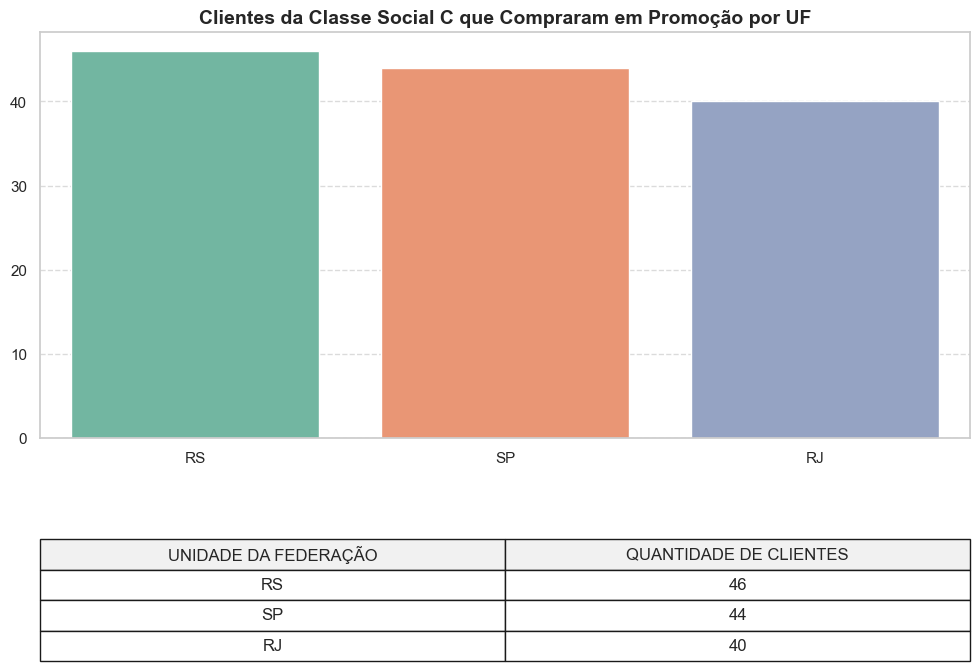

In [30]:
def plot_clientes_por_uf(clientes_promo_por_uf, classe_mais_comprou):
    """
    Função para plotar o gráfico de barras e tabela de clientes por unidade da federação.

    Args:
    - clientes_promo_por_uf: DataFrame contendo as informações de clientes e UF.
    - classe_mais_comprou: Classe social com maior compra.
    """
    sns.set_theme(style="whitegrid")
    clientes_promo_por_uf_sorted = clientes_promo_por_uf.sort_values(by='QUANTIDADE DE CLIENTES', ascending=False)
    
    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='UNIDADE DA FEDERAÇÃO', 
        y='QUANTIDADE DE CLIENTES', 
        hue='UNIDADE DA FEDERAÇÃO',  
        data=clientes_promo_por_uf_sorted,
        palette=sns.color_palette("Set2", n_colors=len(clientes_promo_por_uf['UNIDADE DA FEDERAÇÃO'].unique())),
        legend=False)
    plt.title(f'Clientes da Classe Social {classe_mais_comprou} que Compraram em Promoção por UF', fontsize=14, weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(axis='y', linestyle='--', alpha= 0.7)
    plt.table(
        cellText=clientes_promo_por_uf_sorted.values,
        colLabels=clientes_promo_por_uf_sorted.columns,
        loc='bottom',  
        cellLoc='center', 
        colColours=["#f1f1f1"]*len(clientes_promo_por_uf_sorted.columns),
        bbox=[0.0, -0.55, 1.0, 0.3] 
    )
    plt.subplots_adjust(bottom=0.3)  
    plt.show()


plot_clientes_por_uf(clientes_promo_por_uf, classe_mais_comprou)


**Os clientes da Classe C foram os que mais realizaram compras no período de fevereiro de 2022 a setembro de 2023, conforme os dados disponíveis. Entre eles, 46 adquiriram produtos em promoção no estado do Rio Grande do Sul (RS), 44 em São Paulo (SP) e 40 no Rio de Janeiro (RJ).**

#### Análise em SQL

In [31]:
consulta_sql = """
SELECT 
    c."CLASSE SOCIAL",
    SUM(t."VALOR VENDA") AS "TOTAL VENDA"
FROM transacoes_limpas t
JOIN clientes c 
    ON t."ID CLIENTE" = c."ID CLIENTE"
GROUP BY c."CLASSE SOCIAL"
ORDER BY "TOTAL VENDA" DESC;
"""

vendas_por_classe = con.execute(consulta_sql).fetchdf()
print("\nVendas Totais por Classe Social:")
print(vendas_por_classe)



Vendas Totais por Classe Social:
  CLASSE SOCIAL  TOTAL VENDA
0             C    446077.81
1             D    128447.93
2             B    110213.23
3             A    103425.65
4             E     93923.41
5          None     36594.28


In [32]:
consulta_sql = """
WITH classe_mais_comprou AS (
    SELECT 
        c."CLASSE SOCIAL",
        SUM(t."VALOR VENDA") AS total_vendas
    FROM transacoes_limpas t
    JOIN clientes c ON t."ID CLIENTE" = c."ID CLIENTE"
    GROUP BY c."CLASSE SOCIAL"
    ORDER BY total_vendas DESC
    LIMIT 1
)
SELECT 
    COUNT(*) AS qtd_clientes,
    ANY_VALUE(c."CLASSE SOCIAL") AS "CLASSE SOCIAL"
FROM clientes c
JOIN classe_mais_comprou cmc 
    ON c."CLASSE SOCIAL" = cmc."CLASSE SOCIAL";
"""

resultado = con.execute(consulta_sql).fetchdf()
print(resultado)

   qtd_clientes CLASSE SOCIAL
0            48             C


In [33]:
consulta_sql = """
WITH classe_mais_lucrativa AS (
    SELECT 
        c."CLASSE SOCIAL"
    FROM transacoes_limpas t
    JOIN clientes c ON t."ID CLIENTE" = c."ID CLIENTE"
    GROUP BY c."CLASSE SOCIAL"
    ORDER BY SUM(t."VALOR VENDA") DESC
    LIMIT 1
),

transacoes_filtradas AS (
    SELECT 
        t."ID CLIENTE",
        t."ID LOJA"
    FROM transacoes_limpas t
    JOIN clientes c 
        ON t."ID CLIENTE" = c."ID CLIENTE"
    JOIN classe_mais_lucrativa cls 
        ON c."CLASSE SOCIAL" = cls."CLASSE SOCIAL"
    WHERE t."PROMOÇÃO" = 1
),

clientes_uf AS (
    SELECT 
        tf."ID CLIENTE",
        l."UNIDADE DA FEDERAÇÃO"
    FROM transacoes_filtradas tf
    JOIN lojas_limpas l 
        ON tf."ID LOJA" = l."ID LOJA"
)

SELECT 
    "UNIDADE DA FEDERAÇÃO",
    COUNT(DISTINCT "ID CLIENTE") AS "QUANTIDADE DE CLIENTES"
FROM clientes_uf
GROUP BY "UNIDADE DA FEDERAÇÃO"
ORDER BY "QUANTIDADE DE CLIENTES" DESC;
"""
resultado = con.execute(consulta_sql).fetchdf()
print(resultado)

  UNIDADE DA FEDERAÇÃO  QUANTIDADE DE CLIENTES
0                   RS                      46
1                   SP                      44
2                   RJ                      40


### 2.	Filtrando apenas as transações de peças da COR azul, diga qual foi o TAMANHO que mais vendeu por cada UNIDADE DA FEDERAÇÃO.

#### Análise em Python

In [34]:
print("Cores disponíveis:")
print(transacoes_limpo['COR'].unique())
print("\nTamanhos disponíveis:")
print(transacoes_limpo['TAMANHO'].unique())

Cores disponíveis:
['Cinza' 'Preto' 'Vermelho' 'Azul']

Tamanhos disponíveis:
['P' 'M' 'G' 'GG']


In [35]:
# Join das tabelas de transações e lojas
df_merged = pd.merge(transacoes_limpo, lojas_limpas, on='ID LOJA', how='left')
display(df_merged.head())

,ID TRANSAÇÃO,DATA,ID LOJA,ID PRODUTO,ID CLIENTE,PEÇAS VENDA,DESCRIÇÃO,TAMANHO,COR,VALOR VENDA,PROMOÇÃO,ID CIDADE,UNIDADE DA FEDERAÇÃO,REGIÃO
0,1,2022-01-02,Loja007,123005,90023,2,Blusa em malha,P,Cinza,99.98,0,15428,SP,SUDESTE
1,2,2022-01-02,Loja009,123004,90092,1,Regata,M,Cinza,35.99,0,33005,RJ,SUDESTE
2,3,2022-01-02,Loja001,123001,90027,2,Calça algodão,G,Cinza,51.98,0,20027,RS,SUL
3,4,2022-01-02,Loja003,123001,90097,2,Calça algodão,G,Cinza,51.98,0,20027,RS,SUL
4,5,2022-01-02,Loja004,123004,90089,2,Regata,M,Cinza,71.98,0,20027,RS,SUL


In [36]:
# Validando o número de registros

print(f"Número de linhas na tabela de transações: {len(transacoes_limpo)}")
print(f"Número de linhas após a junção: {len(df_merged)}")

Número de linhas na tabela de transações: 7785
Número de linhas após a junção: 7785


In [37]:
# Apenas transações de cor azul

df_azul = df_merged[df_merged['COR'] == 'Azul']
print(f"Número de transações com peças azuis: {len(df_azul)}")

Número de transações com peças azuis: 793


In [38]:
df_vendas_por_uf_tamanho = df_azul.groupby(['UNIDADE DA FEDERAÇÃO', 'TAMANHO'])['PEÇAS VENDA'].sum().reset_index()
print("Vendas por UF e TAMANHO:")
display(df_vendas_por_uf_tamanho)

Vendas por UF e TAMANHO:


,UNIDADE DA FEDERAÇÃO,TAMANHO,PEÇAS VENDA
0,RJ,G,174
1,RJ,M,89
2,RJ,P,72
3,RS,G,360
4,RS,M,164
5,RS,P,226
6,SP,G,378
7,SP,M,190
8,SP,P,232


In [39]:
# Validação

print("Lojas com UF nula:")
print(lojas_limpas[lojas_limpas['UNIDADE DA FEDERAÇÃO'].isna()])
transacoes_uf_nula = df_merged[df_merged['UNIDADE DA FEDERAÇÃO'].isna()]
print("Número de transações com UF nula:")
print(len(transacoes_uf_nula))

Lojas com UF nula:
Empty DataFrame
Columns: [ID LOJA, ID CIDADE, UNIDADE DA FEDERAÇÃO, REGIÃO]
Index: []
Número de transações com UF nula:
0


In [40]:
df_vendas_por_uf_tamanho = df_azul.groupby(['UNIDADE DA FEDERAÇÃO', 'TAMANHO'])['PEÇAS VENDA'].sum().reset_index()

def tamanho_mais_vendido(grupo):
    idx = grupo['PEÇAS VENDA'].idxmax() 
    return grupo.loc[idx]

df_resultado = (
    df_vendas_por_uf_tamanho
    .sort_values('PEÇAS VENDA', ascending=False)
    .drop_duplicates(subset=['UNIDADE DA FEDERAÇÃO'])
    .sort_values('UNIDADE DA FEDERAÇÃO')
    .reset_index(drop=True)
)

df_resultado = df_resultado.sort_values('UNIDADE DA FEDERAÇÃO')

print("Tamanho que mais vendeu por UF (peças azuis):\n")
display(df_resultado)

Tamanho que mais vendeu por UF (peças azuis):



,UNIDADE DA FEDERAÇÃO,TAMANHO,PEÇAS VENDA
0,RJ,G,174
1,RS,G,360
2,SP,G,378


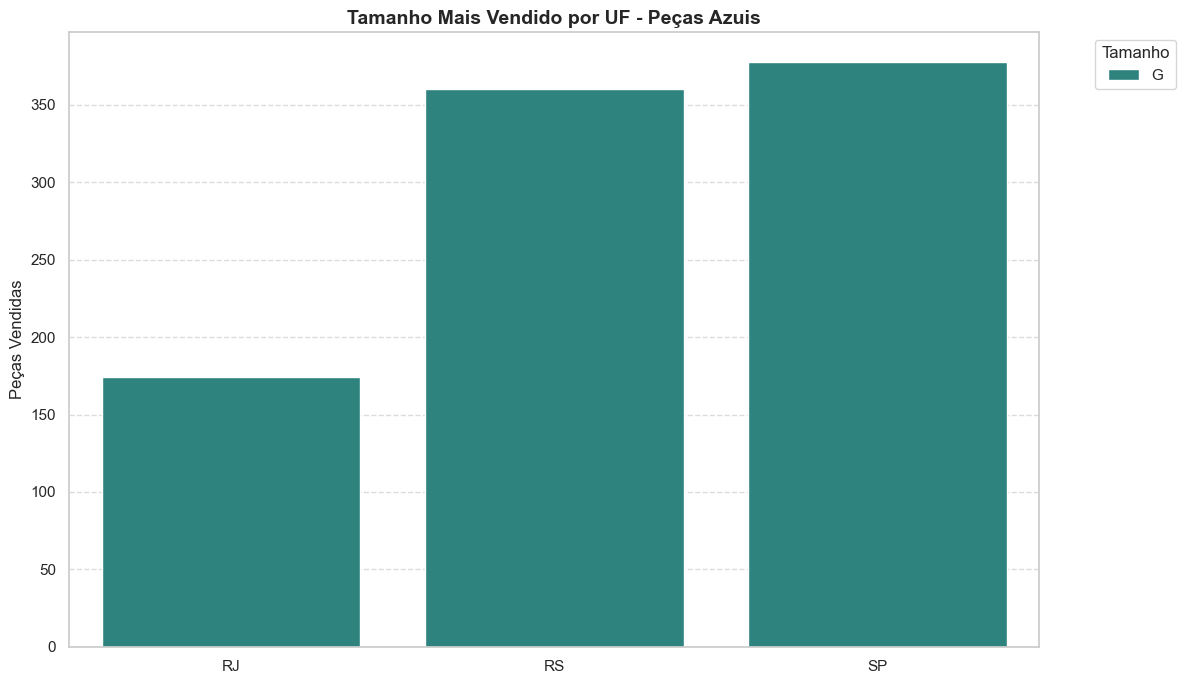

In [41]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_resultado,
    x='UNIDADE DA FEDERAÇÃO',
    y='PEÇAS VENDA',
    hue='TAMANHO',
    palette='viridis'
)

plt.title('Tamanho Mais Vendido por UF - Peças Azuis', fontsize=14, weight='bold')
plt.xlabel('')
plt.ylabel('Peças Vendidas', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Tamanho', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Análise em SQL

In [42]:
consulta_sql = """
WITH PecasAzuis AS (
    SELECT 
        COALESCE(l."UNIDADE DA FEDERAÇÃO", 'Não Informado') AS UF,
        TRIM(t.TAMANHO) AS TAMANHO,
        SUM(t."PEÇAS VENDA") AS TOTAL_VENDIDO
    FROM 
        transacoes_limpas t
    LEFT JOIN 
        lojas_limpas l ON t."ID LOJA" = l."ID LOJA"
    WHERE 
        t.COR = 'Azul'
    GROUP BY 
        COALESCE(l."UNIDADE DA FEDERAÇÃO", 'Não Informado'), 
        TRIM(t.TAMANHO)
),
RankingVendas AS (
    SELECT 
        UF, 
        TAMANHO, 
        TOTAL_VENDIDO,
        RANK() OVER (PARTITION BY UF ORDER BY TOTAL_VENDIDO DESC) AS RANKING
    FROM 
        PecasAzuis
)
SELECT 
    UF AS "UNIDADE DA FEDERAÇÃO",
    TAMANHO,
    TOTAL_VENDIDO AS "PEÇAS VENDIDAS"
FROM 
    RankingVendas
WHERE 
    RANKING = 1
ORDER BY 
    UF;
"""
resultado = con.execute(consulta_sql).fetchdf()
print(resultado)

  UNIDADE DA FEDERAÇÃO TAMANHO  PEÇAS VENDIDAS
0                   RJ       G           174.0
1                   RS       G           360.0
2                   SP       G           378.0


### 3.	Obtenha o tipo do item (definido no campo DESCRIÇÃO) que vendeu mais peças da COR vermelha em 2023 do que em 2022 (em todas as UNIDADES DA FEDERAÇÃO). Qual foi o valor vendido no RS em 2022 para esse tipo de item independentemente da COR?

#### Análise em Python

In [43]:
# Agrupando vendas por descrição e cor
vendas_por_descricao_cor = df_merged.groupby(['DESCRIÇÃO', 'COR'])['PEÇAS VENDA'].sum().reset_index()
print("\nVendas por descrição e cor:\n")
display(vendas_por_descricao_cor)


Vendas por descrição e cor:



,DESCRIÇÃO,COR,PEÇAS VENDA
0,Blusa em malha,Cinza,1969
1,Blusa manga curta,Vermelho,1985
2,Calça Xadrez,Azul,912
3,Calça algodão,Cinza,1473
4,Calça liso,Azul,530
5,Calça pantalona,Vermelho,1938
6,Camisa em viscose,Azul,443
7,Camisa jeans,Vermelho,1911
8,Camisa manga longa,Preto,2002
9,Colete,Preto,1923


In [44]:
# Validando o tipo
df_merged['DATA'] = pd.to_datetime(transacoes['DATA'])

# Filtra vendas da cor vermelha e adiciona o ano
vendas_vermelhas = df_merged[df_merged['COR'].str.lower() == 'vermelho'].copy()
vendas_vermelhas['ANO'] = vendas_vermelhas['DATA'].dt.year

# Agrupa por DESCRIÇÃO e ANO, somando as peças vendidas
vendas_agrupadas = vendas_vermelhas.groupby(['DESCRIÇÃO', 'ANO'])['PEÇAS VENDA'].sum().unstack(fill_value=0).reset_index()

# Filtra os itens que venderam mais em 2023 do que em 2022
vendas_maiores_2023 = vendas_agrupadas[vendas_agrupadas.get(2023, 0) > vendas_agrupadas.get(2022, 0)].copy()

# Ordena por total de vendas em 2023 e pega o item mais vendido
if not vendas_maiores_2023.empty:
    item_top = vendas_maiores_2023.sort_values(by=2023, ascending=False).iloc[0]
    descricao = item_top['DESCRIÇÃO']
    total_vendido = item_top[2023]

    print(f"\nO tipo de item que mais vendeu na cor vermelha em 2023 (mais que em 2022) foi: {descricao}")
    print(f"Com um total de {total_vendido} peças vendidas em 2023.")
else:
    print("\nNenhum item da cor vermelha teve vendas maiores em 2023 do que em 2022.")


O tipo de item que mais vendeu na cor vermelha em 2023 (mais que em 2022) foi: Jaqueta
Com um total de 896 peças vendidas em 2023.


In [45]:
# Calculando o valor vendido no RS em 2022 para esse tipo de item independentemente da cor
vendas_rs_2022 = df_merged[
    (df_merged['DESCRIÇÃO'] == descricao) & 
    (df_merged['UNIDADE DA FEDERAÇÃO'] == 'RS') & 
    (df_merged['DATA'].dt.year == 2022)
]

valor_total_rs = vendas_rs_2022['VALOR VENDA'].sum()
print(f"\nO valor total vendido no RS em 2022 para {descricao} (independente da cor) foi: R$ {valor_total_rs:.2f}")



O valor total vendido no RS em 2022 para Jaqueta (independente da cor) foi: R$ 20835.70


#### Análise em SQL

In [46]:
consulta_sql = """

WITH vendas_vermelhas AS (
    SELECT 
        DESCRIÇÃO,
        EXTRACT(YEAR FROM DATA) AS ANO,
        "PEÇAS VENDA"
    FROM transacoes_limpas
    WHERE LOWER(COR) = 'vermelho'
),
vendas_agrupadas AS (
    SELECT 
        DESCRIÇÃO,
        ANO,
        SUM("PEÇAS VENDA") AS total_vendido
    FROM vendas_vermelhas
    GROUP BY DESCRIÇÃO, ANO
),
vendas_pivot AS (
    SELECT 
        DESCRIÇÃO,
        SUM(CASE WHEN ANO = 2022 THEN total_vendido ELSE 0 END) AS vendas_2022,
        SUM(CASE WHEN ANO = 2023 THEN total_vendido ELSE 0 END) AS vendas_2023
    FROM vendas_agrupadas
    GROUP BY DESCRIÇÃO
),
vendas_maiores_2023 AS (
    SELECT *
    FROM vendas_pivot
    WHERE vendas_2023 > vendas_2022
)
SELECT 
    DESCRIÇÃO,
    vendas_2023,
    vendas_2022
FROM vendas_maiores_2023
ORDER BY vendas_2023 DESC
LIMIT 1;

"""

resultado = con.execute(consulta_sql).fetchdf()
print(resultado)

  DESCRIÇÃO  vendas_2023  vendas_2022
0   Jaqueta        896.0        507.0


In [47]:
consulta_sql = """
SELECT 
    SUM(t."VALOR VENDA") AS valor_total_rs
FROM transacoes_limpas AS t
INNER JOIN lojas_limpas AS l ON t."ID LOJA" = l."ID LOJA"
WHERE 
    t."DESCRIÇÃO" = 'Jaqueta'
    AND l."UNIDADE DA FEDERAÇÃO" = 'RS'
    AND EXTRACT(YEAR FROM t."DATA") = 2022;
"""

resultado = con.execute(consulta_sql).fetchdf()
print(resultado)

   valor_total_rs
0         20835.7


### 4. Para a COR cinza no ano de 2023, assumindo que não há crescimento ou decrescimento da demanda, compare a média e a dispersão, semana a semana, de VALOR VENDA por TAMANHO (P, M e G). Utilize o teste de inferência estatística mais adequado e prove qual TAMANHO tem maior VALOR VENDA médio que os demais (precisa mostrar a significância estatística).

#### Análise em Python

In [48]:
# Validando os dados e adicionando colunas para ano, mês e semana
transacoes_limpo['DATA'] = pd.to_datetime(transacoes_limpo['DATA'], format='%d/%m/%Y')
transacoes_limpo['ANO'] = transacoes_limpo['DATA'].dt.year
transacoes_limpo['MES'] = transacoes_limpo['DATA'].dt.month
transacoes_limpo['SEMANA'] = transacoes_limpo['DATA'].dt.isocalendar().week
transacoes_limpo.head()

,ID TRANSAÇÃO,DATA,ID LOJA,ID PRODUTO,ID CLIENTE,PEÇAS VENDA,DESCRIÇÃO,TAMANHO,COR,VALOR VENDA,PROMOÇÃO,ANO,MES,SEMANA
0,1,2022-01-02,Loja007,123005,90023,2,Blusa em malha,P,Cinza,99.98,0,2022,1,52
1,2,2022-01-02,Loja009,123004,90092,1,Regata,M,Cinza,35.99,0,2022,1,52
2,3,2022-01-02,Loja001,123001,90027,2,Calça algodão,G,Cinza,51.98,0,2022,1,52
3,4,2022-01-02,Loja003,123001,90097,2,Calça algodão,G,Cinza,51.98,0,2022,1,52
4,5,2022-01-02,Loja004,123004,90089,2,Regata,M,Cinza,71.98,0,2022,1,52


In [49]:
df_cinza = transacoes_limpo[
    (transacoes_limpo['COR'] == 'Cinza') & 
    (transacoes_limpo['ANO'] == 2023)
]
df_cinza = df_cinza[df_cinza['TAMANHO'].isin(['P', 'M', 'G'])]
print(f"Total de registros para cor cinza e tamanhos P, M e G: {len(df_cinza)}")
print("\nDistribuição por tamanho:")
print(df_cinza['TAMANHO'].value_counts())
print("\nAmostra dos dados filtrados:")
df_cinza.head()

Total de registros para cor cinza e tamanhos P, M e G: 1032

Distribuição por tamanho:
TAMANHO
P    432
M    395
G    205
Name: count, dtype: int64

Amostra dos dados filtrados:


,ID TRANSAÇÃO,DATA,ID LOJA,ID PRODUTO,ID CLIENTE,PEÇAS VENDA,DESCRIÇÃO,TAMANHO,COR,VALOR VENDA,PROMOÇÃO,ANO,MES,SEMANA
3877,9001,2023-01-01,Loja009,123005,90088,1,Blusa em malha,P,Cinza,42.99,0,2023,1,52
3880,9004,2023-01-01,Loja006,123005,90096,3,Blusa em malha,P,Cinza,128.97,0,2023,1,52
3882,9006,2023-01-01,Loja007,123001,90050,1,Calça algodão,G,Cinza,24.99,0,2023,1,52
3884,9008,2023-01-01,Loja003,123005,90074,3,Blusa em malha,P,Cinza,128.97,0,2023,1,52
3886,9010,2023-01-01,Loja010,123001,90041,1,Calça algodão,G,Cinza,24.99,0,2023,1,52


In [50]:
stats_semanais = df_cinza.groupby(['SEMANA', 'TAMANHO'])['VALOR VENDA'].agg(['mean', 'std', 'count']).reset_index()
stats_semanais.columns = ['SEMANA', 'TAMANHO', 'MEDIA_VALOR', 'DESVIO_PADRAO', 'CONTAGEM']
stats_semanais = stats_semanais.sort_values(['SEMANA', 'TAMANHO'])
stats_semanais['MEDIA_VALOR'] = stats_semanais['MEDIA_VALOR'].round(2)
stats_semanais['DESVIO_PADRAO'] = stats_semanais['DESVIO_PADRAO'].round(2)
print("Estatísticas semanais por tamanho:")
stats_semanais

Estatísticas semanais por tamanho:


,SEMANA,TAMANHO,MEDIA_VALOR,DESVIO_PADRAO,CONTAGEM
0,1,G,37.48,17.67,2
1,1,M,110.03,29.89,7
2,1,P,111.77,49.02,5
3,2,G,61.09,18.15,9
4,2,M,96.68,32.43,11
...,...,...,...,...,...
115,39,M,85.85,28.14,17
116,39,P,105.54,45.84,10
117,52,G,49.98,24.99,5
118,52,M,35.99,NaN,1


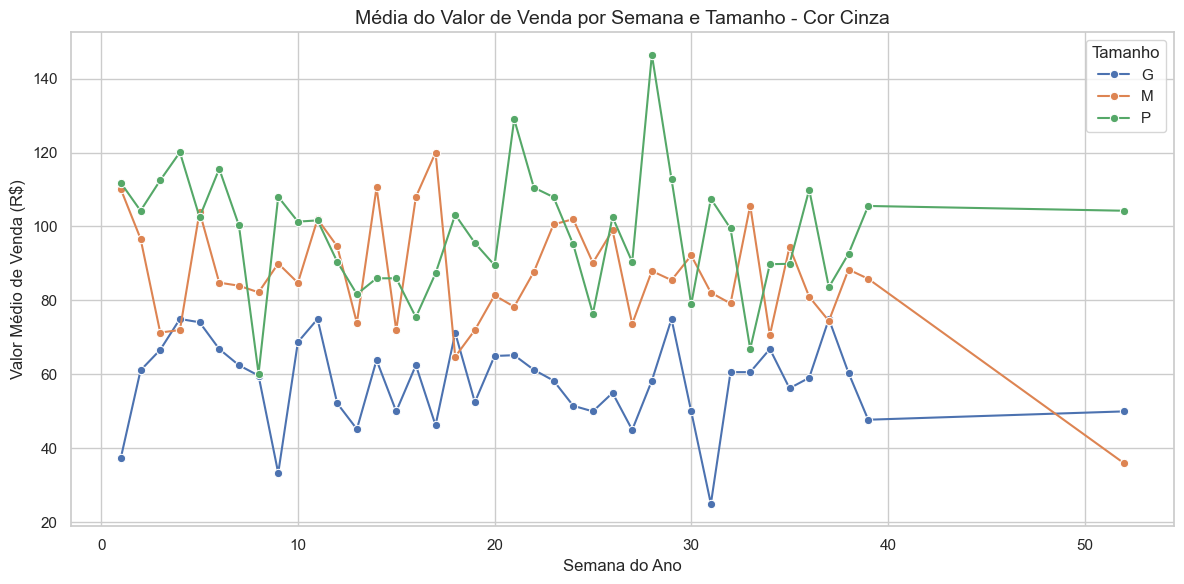

In [51]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='SEMANA', y='MEDIA_VALOR', hue='TAMANHO', data=stats_semanais, marker='o')
plt.title('Média do Valor de Venda por Semana e Tamanho - Cor Cinza', fontsize=14)
plt.xlabel('Semana do Ano', fontsize=12)
plt.ylabel('Valor Médio de Venda (R$)', fontsize=12)
plt.grid(True)
plt.legend(title='Tamanho')
plt.tight_layout()
plt.show()

Tamanhos maiores (G/M) mostram menor variação sazonal, entretanto o tamanho P apresenta comportamento mais cíclico.
Tamanho P poderia ter preços mais dinâmicos para capitalizar períodos de alta demanda, enquanto os tamanhos G/M podem manter preços mais estáveis.


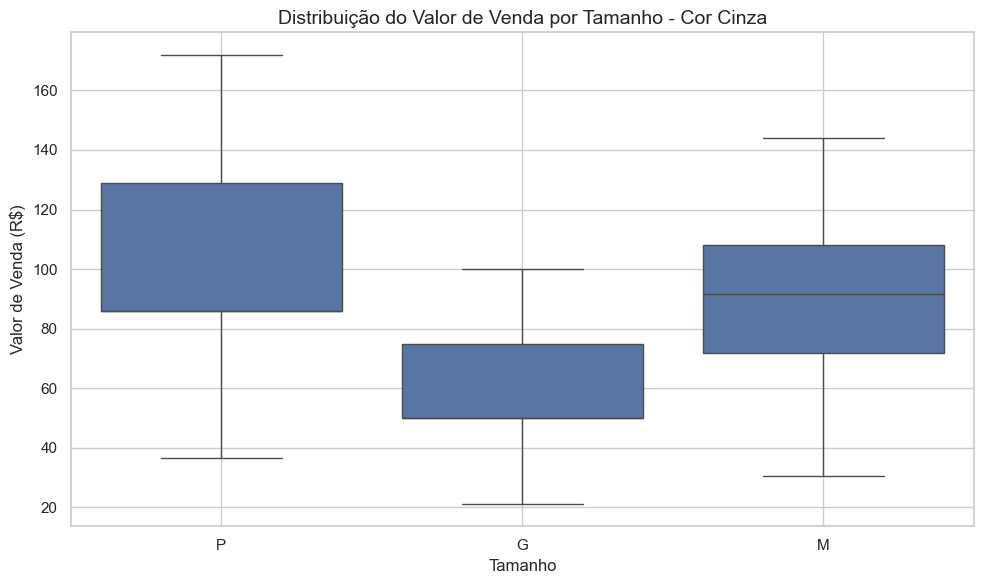

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TAMANHO', y='VALOR VENDA', data=df_cinza)
plt.title('Distribuição do Valor de Venda por Tamanho - Cor Cinza', fontsize=14)
plt.xlabel('Tamanho', fontsize=12)
plt.ylabel('Valor de Venda (R$)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Possível oportunidade para revisar preço do tamanho P (grande variação).
O tamanho G mostra menor variabilidade, sugerindo percepção mais consistente de valor.

ANOVA é um teste estatístico que compara as médias de três ou mais grupos para ver se há diferenças significativas entre eles.
Ele analisa se a variação entre os grupos (ex.: tamanhos P, M, G) é maior que a variação dentro de cada grupo.
Se encontrar diferença significativa (p-valor < 0,05), indica que pelo menos um grupo se destaca dos demais (mas não diz qual).

In [53]:
# Agrupando os dados de valor venda por tamanho
tamanho_p = df_cinza[df_cinza['TAMANHO'] == 'P']['VALOR VENDA']
tamanho_m = df_cinza[df_cinza['TAMANHO'] == 'M']['VALOR VENDA']
tamanho_g = df_cinza[df_cinza['TAMANHO'] == 'G']['VALOR VENDA']

# Realizando o teste ANOVA
f_statistic, p_value = stats.f_oneway(tamanho_p, tamanho_m, tamanho_g)
print(f"Teste ANOVA para comparação dos valores médios de venda entre tamanhos:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretação do resultado
alpha = 0.05

if p_value < alpha:
    print("\nConclusão: Rejeitamos a hipótese nula.")
    print("Existe pelo menos uma diferença significativa no valor médio de venda entre os tamanhos.")
else:
    print("\nConclusão: Não rejeitamos a hipótese nula.")
    print("Não há evidências suficientes para afirmar que existem diferenças significativas nos valores médios de venda entre os tamanhos.")

Teste ANOVA para comparação dos valores médios de venda entre tamanhos:
F-statistic: 98.2411
p-value: 0.0000

Conclusão: Rejeitamos a hipótese nula.
Existe pelo menos uma diferença significativa no valor médio de venda entre os tamanhos.


Uma vez que o teste ANOVA indica diferenças significativas, vamos realizar um teste post-hoc (Tukey HSD) para identificar quais pares de tamanhos diferem significativamente.

In [54]:
df_tukey = pd.DataFrame({
    'valor': pd.concat([tamanho_p, tamanho_m, tamanho_g], ignore_index=True),
    'grupo': pd.concat([
        pd.Series(['P'] * len(tamanho_p)),
        pd.Series(['M'] * len(tamanho_m)),
        pd.Series(['G'] * len(tamanho_g))
    ], ignore_index=True)
})

tukey_results = pairwise_tukeyhsd(df_tukey['valor'], df_tukey['grupo'], alpha=0.05)
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     G      M  30.0288    0.0 23.2953 36.7624   True
     G      P  39.3752    0.0 32.7409 46.0094   True
     M      P   9.3463 0.0002  3.9006  14.792   True
----------------------------------------------------


Os produtos seguem uma hierarquia de preços consistente (G > M > P), com diferenças reais (99.8%+ de confiança).

## Conclusão 

Este notebook teve como objetivo principal analisar os dados de vendas de uma empresa varejista, buscando responder a perguntas estratégicas formuladas pela área Comercial.
Por meio de técnicas de manipulação de dados, filtragem e análise estatística, foram extraídos insights sobre o comportamento de compra dos clientes, segmentação por classe social, preferências por cor e tamanho, além da performance geográfica (Unidades da Federação).  

#### **Principais Resultados**  
1. **Classe C como Principal Público-Alvo**:  
   - A classe social que mais contribuiu para o faturamento foi a **Classe C**, com destaque para os estados do **RS, SP e RJ** em compras de produtos em promoção.  
   - **Possíveis ações**: Direcionar campanhas promocionais específicas para essa classe nesses estados, potencializando vendas e fidelização.  

2. **Preferência por Tamanho G em Peças Azuis**:  
   - O **tamanho G** foi o mais vendido em todas as UFs analisadas para a cor azul.  
   - **Possíveis ações*: Ajustar o estoque e o mix de produtos, priorizando esse tamanho, e avaliar se a demanda se repete em outras cores.  

3. **Crescimento de Vendas de Jaquetas Vermelhas**:  
   - **Jaquetas vermelhas** tiveram maior volume de vendas em **2023** comparado a 2022, com destaque para o RS, que registrou **R$ 20.835,70** em vendas desse item em 2022.  
   - **Possíveis ações**: Investir em marketing sazonal para jaquetas, especialmente em cores de alta demanda, e monitorar tendências semelhantes em outras regiões.  

4. **Análise Estatística para a Cor Cinza (2023)**:  
   - Através de **testes de hipóteses (ANOVA)**, foi possível identificar que o **tamanho G** apresentou **maior valor médio de venda** com **significância estatística** em comparação aos tamanhos P e M.  
   - **Ação Recomendada**: Ajustar estratégias de precificação e estoque para o tamanho G, além de investigar se esse padrão se repete em outras cores.  

#### **Impacto**  
Os resultados obtidos fornecem dados para:  
- **Avaliar e otimizar estoques** (evitando excessos ou falta de produtos-chave).  
- **Personalizar promoções** (direcionando descontos para clientes da Classe C em regiões estratégicas).  
- **Refinar estratégias de marketing** (como campanhas focadas em jaquetas vermelhas e tamanho G).  


Em resumo, este notebook não apenas respondeu às perguntas iniciais, mas também gerou conhecimento acionável, permitindo que a empresa tome decisões baseadas em dados para aumentar receita, eficiência e satisfação do cliente.  
